## ML-Speech Pro school

In [0]:
!pip install torch
!apt-get install sox libsox-dev libsox-fmt-all
!pip install setuptools --upgrade
!pip install librosa
!pip install git+git://github.com/pytorch/audio
!pip install livelossplot
!pip install tqdm

In [0]:
# !apt-get install -y -qq software-properties-common python-software-properties module-init-tools
# !add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
# !apt-get update -qq 2>&1 > /dev/null
# !apt-get -y install -qq google-drive-ocamlfuse fuse

# from google.colab import auth
# auth.authenticate_user()
# from oauth2client.client import GoogleCredentials
# creds = GoogleCredentials.get_application_default()
# import getpass

# !google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
# vcode = getpass.getpass()
# !echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

In [0]:
# !mkdir -p drive
# !google-drive-ocamlfuse drive
# !ls drive

In [0]:
import torch
import numpy as np
from torch import nn
import torchaudio
import os
from matplotlib import pyplot as plt
import pandas as pd
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import LabelEncoder
from livelossplot import PlotLosses
from tqdm import tqdm, tqdm_notebook
from sklearn.metrics import accuracy_score

%matplotlib inline

In [0]:
WORKDIR_PATH = "drive/DeepLearning"

In [0]:
le1 = LabelEncoder().fit(['background', 'bags', 'door', 'keyboard', 'knocking_door', 'ring', 'speech', 'tool'])
le2 = LabelEncoder().fit(['scream', 'laughter', 'car', 'acoustic_guitar', 'airplane', 'ocean_surf', 'squeak', 
                         'whistle', 'bird', 'speech_fs', 'rustle', 'applause', 'church_bell', 'tone', 'hammer', 
                         'violin', 'fireworks', 'engine', 'child', 'footstep', 'knock', 'water_tap', 'helicopter', 
                         'mouse_click', 'dog_barking', 'cat', 'crowd', 'glass_breaking'])

In [0]:
class AudioDataset(Dataset):
    def __init__(self, csv_file_path, npy_file_path, y_le=None):
        csv_file = pd.read_csv(csv_file_path)

        self.le = y_le
        self.target = csv_file["target"].get_values()
        
        if y_le is None:
            self.encoded_target = self.target
        else:
            self.encoded_target = y_le.transform(self.target)
        self.mels = np.load(npy_file_path)
        
    def __len__(self):
        return len(self.mels)
    
    def __getitem__(self, idx):
        mel = self.mels[idx]
        mel = mel/mel.sum()
        encoded_label = self.encoded_target[idx]
        
        if self.le is not None:
            return {"mel": mel, "target": encoded_label}
        else:
            return {"mel": mel}

In [0]:
class ConvNet(nn.Module):
    def __init__(self, num_classes=10, p=0.5):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Dropout(p=p),
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=4),
            nn.Dropout(p=0.1),
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(p=0.2)
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(p=0.2)
        )
        self.fc = nn.Linear(11*8*128, num_classes)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out

In [48]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print("Device:", device)

Device: cuda:0


## Pretrain Model

In [0]:
model = ConvNet(num_classes=len(le2.classes_), p=0.2).to(device)

In [0]:
train_dataset = AudioDataset(WORKDIR_PATH+"/train-pretrain.csv", WORKDIR_PATH+"/train-pretrain.npy", le2)
val_dataset = AudioDataset(WORKDIR_PATH+"/val-pretrain.csv", WORKDIR_PATH+"/val-pretrain.npy", le2)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=True, num_workers=4)

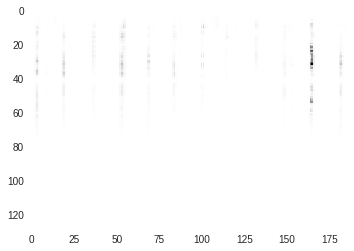

In [51]:
plt.imshow(train_dataset[123]["mel"][0])

In [0]:
num_epochs = 100
learning_rate = 0.0005

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

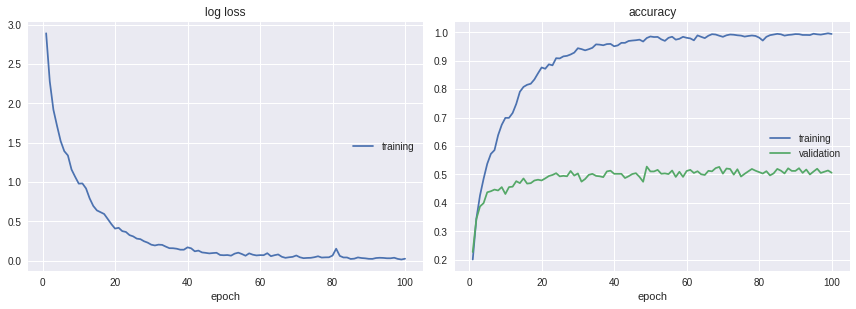

In [53]:
liveloss = PlotLosses()
total_step = len(train_dataloader)
for epoch in range(num_epochs):
    epoch_losses = []
    epoch_accuracy = []
    
    for batch in train_dataloader:
        mels = batch["mel"].to(device)
        labels = batch["target"].to(device)
        
        outputs = model(mels)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_losses.append(loss.item())
        epoch_accuracy.append(accuracy_score(torch.argmax(outputs, 1), labels))
#         print("Epoch: %s;Batch: %s;Loss: %s" % (epoch, i, loss.item()))
    
    accuracy_val = []
    for batch in val_dataloader:
        mels = batch["mel"].to(device)
        labels = batch["target"].data.numpy()

        out = model(mels)
        pred = torch.argmax(out, 1).cpu().data.numpy()
        accuracy_val.append(accuracy_score(pred, labels))
    
    liveloss.update({
        'log loss': np.mean(epoch_losses),
        'accuracy': np.mean(epoch_accuracy),
        'val_accuracy': np.mean(accuracy_val)
    })
    liveloss.draw()

## Train main model

In [0]:
model.fc = nn.Linear(11*8*128, len(le1.classes_)).to(device)

In [0]:
train_dataset = AudioDataset(WORKDIR_PATH+"/train.csv", WORKDIR_PATH+"/train.npy", le1)
val_dataset = AudioDataset(WORKDIR_PATH+"/val.csv", WORKDIR_PATH+"/val.npy", le1)

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=True, num_workers=4)

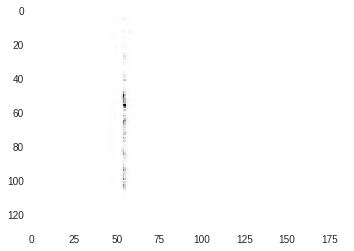

In [56]:
plt.imshow(train_dataset[123]["mel"][0])

In [0]:
num_epochs = 100
learning_rate = 0.0001

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [0]:
from sklearn.metrics import accuracy_score

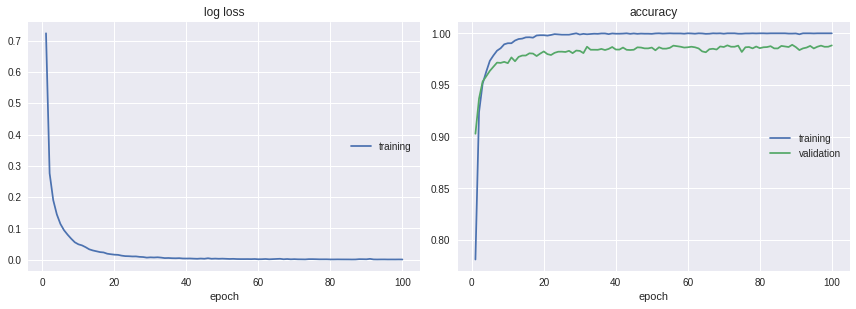

In [59]:
liveloss = PlotLosses()
total_step = len(train_dataloader)

for epoch in range(num_epochs):
    epoch_losses = []
    epoch_accuracy = []
    
    for batch in train_dataloader:
        mels = batch["mel"].to(device)
        labels = batch["target"].to(device)
        
        outputs = model(mels)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_losses.append(loss.item())
        epoch_accuracy.append(accuracy_score(torch.argmax(outputs, 1), labels))
#         print("Epoch: %s;Batch: %s;Loss: %s" % (epoch, i, loss.item()))
    
    accuracy_val = []
    for batch in val_dataloader:
        mels = batch["mel"].to(device)
        labels = batch["target"].data.numpy()

        out = model(mels)
        pred = torch.argmax(out, 1).cpu().data.numpy()
        accuracy_val.append(accuracy_score(pred, labels))
    
    liveloss.update({
        'log loss': np.mean(epoch_losses),
        'accuracy': np.mean(epoch_accuracy),
        'val_accuracy': np.mean(accuracy_val)
    })
    liveloss.draw()

In [60]:
accuracy_val = []
for batch in val_dataloader:
    mels = batch["mel"].to(device)
    labels = batch["target"].data.numpy()
    
    out = model(mels)
    pred = torch.argmax(out, 1).cpu().data.numpy()
    accuracy_val.append(accuracy_score(pred, labels))

print("Test accuracy:", np.mean(accuracy_val))

Test accuracy: 0.9886122881355932


In [0]:
test_dataset = AudioDataset(WORKDIR_PATH+"/test.csv", WORKDIR_PATH+"/test.npy")
test_dataloader = DataLoader(test_dataset, batch_size=32)

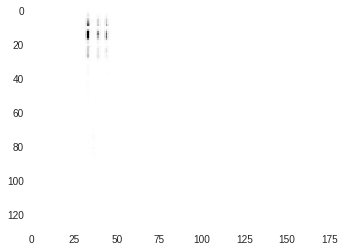

In [62]:
test_csv = pd.read_csv(WORKDIR_PATH+"/test.csv", index_col=0)
test_csv.head()

plt.imshow(test_dataset[5]["mel"][0])
plt.show()

In [0]:
submit_proba = []
submit_labels = []

for batch in test_dataloader:
    mel = batch["mel"].to(device)
    model_output = nn.Softmax(dim=1)(model.forward(mel))
    proba, labels = model_output.max(dim=1)
    proba = proba.cpu().data.numpy()
    labels = labels.cpu().data.numpy()

    submit_proba.append(proba)
    submit_labels.append(labels)

In [0]:
submit_proba = np.concatenate(submit_proba)
submit_labels = np.concatenate(submit_labels)

In [65]:
test_csv["target"] = le1.inverse_transform(submit_labels)
test_csv["proba"] = submit_proba
test_csv = test_csv[["name", "proba", "target"]]
test_csv.head()

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


,name,proba,target
0,unknown_0063.wav,0.998171,door
1,unknown_0077.wav,0.999739,keyboard
2,unknown_0088.wav,0.823622,tool
3,keyboard_0035.wav,1.000000,keyboard
4,knocking_door_t_0002.wav,0.999997,knocking_door


In [0]:
test_csv.to_csv(WORKDIR_PATH+"/my_result.txt", index=False, header=False, sep="\t")

In [67]:
accuracy_val = []
for batch in val_dataloader:
    mels = batch["mel"].to(device)
    labels = batch["target"].data.numpy()
    
    out = model(mels)
    pred = torch.argmax(out, 1).cpu().data.numpy()
    accuracy_val.append(accuracy_score(pred, labels))

print("Test accuracy:", np.mean(accuracy_val))

Test accuracy: 0.9886122881355932
